In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
import time
from sklearn.metrics import explained_variance_score

In [2]:
class AP_GRU_Single(nn.Module):
    def __init__(self, H_no, device):
        super().__init__()
        
        self.H_no = H_no
        self.device = device
        
        self.rnn = nn.GRU(1, H_no, batch_first=True)
        self.linear = nn.Linear(H_no, 1)
        
    def forward(self, V):
        #V is shape (batch, 50000)

        rnn_out, _ = self.rnn(V.unsqueeze(2)) #(batch,50000,H)
        rnn_out = rnn_out.reshape(-1,self.H_no)
        lin_out = self.linear(rnn_out) #(batch*50000,1)
        lin_out = lin_out.reshape(V.shape[0], V.shape[1])
        
        return lin_out



In [3]:
batch_size = 20
batch_length = 50000
H_no = 30
device = torch.device("cuda")

epoch_no = 400
iter_no = epoch_no * 980 // batch_size

#V = np.load("/media/hdd01/sklee/CA1_clust4-60/data/vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy").reshape(-1,50001)[:,:50000].flatten()
V = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/comb_pred/V_comb_pred.npy")
S = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/data/V_diff_stimseed1.npy").reshape(-1,batch_length)

V-= np.mean(V)

V = torch.from_numpy(V)
S = torch.from_numpy(S)


In [4]:
V_train = V[:980].float()
V_test = V[980:].float().to(device)
S_train = S[:980].float()
S_test = S[980:].float() .to(device)

train_idx = np.empty((epoch_no, 980))
for i in range(epoch_no):
    part_idx = np.arange(0,980,1)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.reshape(-1, batch_size)
train_idx = torch.from_numpy(train_idx).long()
print(train_idx.shape)

torch.Size([19600, 20])


In [5]:
model = AP_GRU_Single(H_no, device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.025, momentum=0.9)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

bce_criterion = nn.BCELoss(reduction="mean")

3001


In [6]:
score_list = []

part_time_idx = torch.arange(0,50000)

for i in tnrange(iter_no):
    s = time.time()
    model.train()
    optimizer.zero_grad()
    
    batch_idx = train_idx[i]
    batch_S = S_train[batch_idx].to(device)[:,part_time_idx]
    batch_V = V_train[batch_idx].to(device)[:,part_time_idx]
    
    S_out = model(batch_V)
    loss = torch.mean((S_out - batch_S)**2)
    #loss = torch.var(S_out - batch_S)
    
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), 20)
    optimizer.step()
    
    step_time = time.time() - s
    
    if (i%50 == 49) or (i == 0):
        model.eval()
        test_S_out = model(V_test[:,part_time_idx])
        test_loss = explained_variance_score(S_test[:,part_time_idx].cpu().detach().numpy().flatten(), test_S_out.cpu().detach().numpy().flatten())
        train_loss = explained_variance_score(batch_S.cpu().detach().numpy().flatten(), S_out.cpu().detach().numpy().flatten())
        test_mse = torch.mean((test_S_out - S_test)**2).item()
        
        score_list.append(test_loss)
        print(i, test_loss, train_loss, test_mse)

<ipython-input-6-af9539863d0c>:5: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


  0%|          | 0/19600 [00:00<?, ?it/s]

0 0.0003827810287475586 -0.0004233121871948242 9.973074913024902
49 0.013148188591003418 0.012608110904693604 9.714152336120605
99 0.020048856735229492 0.01978522539138794 9.645573616027832
149 0.03077143430709839 0.030443966388702393 9.540029525756836
199 0.03292006254196167 0.03701525926589966 9.519305229187012
249 0.04587477445602417 0.04645681381225586 9.391395568847656
299 0.04842674732208252 0.047537803649902344 9.367053985595703
349 0.0654035210609436 0.0674816370010376 9.200705528259277
399 0.09021586179733276 0.08586889505386353 8.956122398376465
449 0.11316561698913574 0.1140630841255188 8.729945182800293
499 0.12400281429290771 0.12780791521072388 8.622481346130371
549 0.1408458948135376 0.1255817413330078 8.46020793914795
599 0.15460777282714844 0.14969408512115479 8.326411247253418
649 0.1782044768333435 0.15144628286361694 8.088888168334961
699 0.14784014225006104 0.11490517854690552 8.391340255737305
749 0.15844625234603882 0.14718759059906006 8.284000396728516
799 0.185

6649 0.3051740527153015 0.28983694314956665 6.841545581817627
6699 0.29703575372695923 0.30194926261901855 6.919216156005859
6749 0.2997090220451355 0.18182015419006348 6.89290189743042
6799 0.2955971956253052 0.2606762647628784 6.933443069458008
6849 0.2858157753944397 0.2785646915435791 7.029648780822754
6899 0.3026801347732544 0.2646726965904236 6.864427089691162


KeyboardInterrupt: 

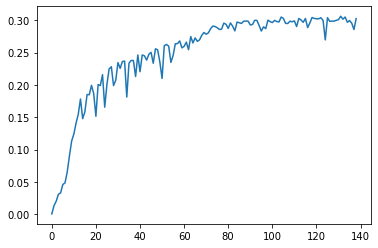

In [7]:
plt.plot(np.asarray(score_list))

(23000.0, 26000.0)

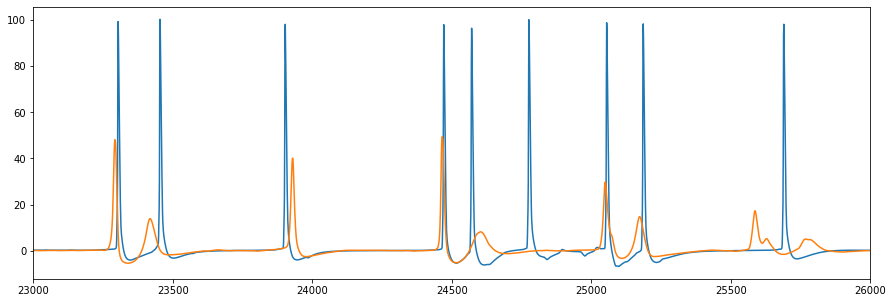

In [8]:
plt.figure(figsize = (15,5))
plt.plot(S_test[0].cpu().detach().numpy()[part_time_idx])
plt.plot(test_S_out[1].cpu().detach().numpy())
plt.xlim(23000,26000)
#plt.ylim(-1,10)

In [9]:
#torch.save(model.state_dict(), "/media/hdd01/sklee/CA1_clust4-60_AP/comb_pred/gru_h30.pt")
#np.save("/media/hdd01/sklee/CA1_clust4-60_AP/comb_pred/gru_h30_test.npy", test_S_out.cpu().detach().numpy())